In [1]:
!pip install --upgrade tables

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [2]:



# Upload the train file from your local drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [3]:
cd /content/drive/My\ Drive/Dr_AI

/content/drive/My Drive/Dr_AI


In [0]:
!ls ../word2vec-pytorch-master/

In [0]:
import pandas as pd
import torch 
from torch import nn
from collections import defaultdict


import numpy as np
from torch.utils.data import DataLoader
from torchtext.data import Field, Dataset, Example
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,hamming_loss

import pickle

In [0]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle
)

In [6]:
tokenizer.sequences_to_texts([[1,2,3]])

['potassium_chloride insulin furosemide']

In [0]:

class DataFrameDataset(Dataset):
 """Class for using pandas DataFrames as a datasource"""
#  def __init__(self, fields, path='./test1.h5', filter_pred=None):
 def __init__(self, fields, examples, filter_pred=None): 
    """
     Create a dataset from a pandas dataframe of examples and Fields
     Arguments:
         examples pd.DataFrame: DataFrame of examples
         fields {str: Field}: The Fields to use in this tuple. The
             string is a field name, and the Field is the associated field.
         filter_pred (callable or None): use only exanples for which
             filter_pred(example) is true, or use all examples if None.
             Default is None
    """
#     examples = pd.read_hdf(path)
    self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
    if filter_pred is not None:
         self.examples = filter(filter_pred, self.examples)
    self.fields = dict(fields)
     # Unpack field tuples
    for n, f in list(self.fields.items()):
         if isinstance(n, tuple):
            self.fields.update(zip(n, f))
            del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""

    @classmethod 
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        fields = dict(fields)
#         print(fields.items())
        for key, field in fields.items():
#             print(key)
            if key not in data:
                 raise ValueError("Specified key {} was not found in "
         "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
#                 print(field.preprocess(data[key]))   
            else:
                 setattr(ex, key, data[key])
#         print(ex.input.pad_)        
        return ex

In [0]:
LABEL = Field(sequential=True,use_vocab=False,batch_first=True,pad_token=[0]*2806)
INPUT = Field(sequential=True,use_vocab=False,batch_first=True,pad_token=[0]*1343)
LENGTH = Field(sequential=False,use_vocab=False,batch_first=True,pad_token=0)

In [0]:
fields = [('label',LABEL),('input',INPUT),('length',LENGTH)]

In [0]:
final_df2 = pd.read_hdf('./m_test.h5')

In [0]:
final_df2.columns
final_df2 = final_df2.rename({'labels':'label', 'lengths':'length'},axis=1)

In [0]:
train_set, test = train_test_split(final_df2, test_size=0.1)
train_set, val = train_test_split(train_set, test_size=0.2)

In [0]:
train_ds = DataFrameDataset(fields, train_set)
val_ds = DataFrameDataset(fields, val)

In [0]:
test_ds = DataFrameDataset(fields=fields, examples=test)

In [0]:
BATCH_SIZE = 64


 


In [0]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [0]:
# device = torch.device("cpu")

In [0]:
from torchtext.data import Iterator, BucketIterator

train_iter, val_iter, test_iter = BucketIterator.splits(
 (train_ds,val_ds,test_ds), # we pass in the datasets we want the iterator to draw data from
 batch_sizes=(BATCH_SIZE, BATCH_SIZE,BATCH_SIZE),
 device=device, # if you want to use the GPU, specify the GPU number here
 sort_key=lambda x: x.length, # the BucketIterator needs to be told what function it should use to group the data.
 sort_within_batch=True,
 repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)
# test_iter = Iterator(tst, batch_size=64, device=-1, sort=False, sort_within_batch=False, repeat=False)

In [0]:
# for batch in train_iter:
#     print(f'{batch.input[0]}')

In [0]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, num_emd, drop_prob=0.2, wv_file=None, tokenizer=None ):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        self.embedding = nn.Embedding(embedding_dim=input_dim, num_embeddings=num_emd, padding_idx=0)
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.wv_file =  wv_file
        self.tokenizer = tokenizer
        
    def forward(self, x,length):
        out = self.embedding(x)
#         print(f'before sum {out.shape}')

        out = out.sum(dim=-2)
        # print(f'before packing {out.shape} ')
        out = torch.nn.utils.rnn.pack_padded_sequence(out, lengths=length, batch_first=True, enforce_sorted=True)
        # print(f'after packing {out.data.shape}  {out.batch_sizes} {length} {out}')
           
        packed_output, h = self.gru(out)
        out, out_lengths = torch.nn.utils.rnn.pad_packed_sequence(packed_output)
#         print(f'after unpacking {out.shape} {out_lengths.shape}')
        out = out.transpose(0,1)
        out = self.fc(out)

        out=self.sigmoid(out)
        return out, h
    
    def init_weights( self, batch_size):
        
      if self.wv_file:
          print(self.wv_file)
          from gensim.models import KeyedVectors, Word2Vec

          wv = KeyedVectors.load(self.wv_file)
          word_indexer  = self.tokenizer.word_index
          
          wv_2 = {}

          for word in word_indexer:
              try:
                  wv_2[word_indexer[word]]= wv[word]
              except KeyError as k:
                  wv_2[word_indexer[word]] = np.zeros(wv.vector_size)

          wv_2
          x = [v for k, v in sorted(wv_2.items(), key=lambda item: item[0], reverse=False)]

          pad = np.zeros_like(x[0])
          x.insert(0,pad)
          y = torch.tensor(x, dtype=torch.float32)
          
          device = self.embedding.weight.device
          self.embedding.weight =  torch.nn.Parameter(y)
          self.embedding = self.embedding.to(device)
          self.gru = nn.GRU(wv.vector_size, self.hidden_dim, self.n_layers, batch_first=True, dropout=self.drop_prob).to(device)

      self.init_hidden(batch_size)

          
    def init_hidden(self, batch_size ):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def compute_loss(model, iterator, criterion):
    loss = 0
    for batch in iterator:
        text = batch.input
        text_lengths = batch.length

        predictions,h = model(text, text_lengths)
#         print(f'predictions.shape {predictions}')
#         print(f'\n\n labels \n{batch.label.dtype} \n\n predictions\n {predictions.dtype}')
        label = batch.label.to(dtype=torch.float32)
        loss += criterion(predictions, label).item()
    return loss/len(iterator)

In [0]:
k = 30

In [0]:
def ham_loss(model, iterator, k=60):
    acc = 0
    n_samples = 0
    recall = []
    
    for batch in iterator:
        text = batch.input
        text_lengths = batch.length

        predictions,h = model(text, text_lengths)
        predictions = (predictions.detach().cpu().numpy()).reshape(predictions.shape[0]*predictions.shape[1],-1)
        labels = np.array(batch.label.cpu()).reshape(batch.label.shape[0]*batch.label.shape[1],-1)
        
#         pred_seq = [np.where(x[0]==1)[0] for x in predictions]
        label_seq = [np.where(x==1)[0] for x in labels]
#         predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1],-1)
        try :    
            for p,q in zip(label_seq,predictions):
                pred =np.sort(np.argsort(q)[-k:])
                acc += (np.intersect1d(pred,p)).size
                n_samples+=(p.size)   
                rec = (np.intersect1d(pred,p)).size/p.size
                recall.append(rec)
    #             print(acc)
    #             print(n_samples, len(p))
    #         acc += np.sum(np.not_equal(pred_seq, label_seq))
        except ZeroDivisionError as z:
            continue
        
    return(np.mean(recall))       

In [0]:

def train(model, train_iterator, optimizer, criterion, val_iterator,epochs=100):
    
    metrics = []
    epoch_loss = 0
    val_loss = 0
    
    model.train()
    h = model.init_weights(batch_size=BATCH_SIZE)

    for epoch in range(epochs):  
        epoch_loss = 0
        for batch in train_iterator:

            optimizer.zero_grad()

            text = batch.input
            text_lengths = batch.length
            # print(text)
            predictions,h = model(text, text_lengths)
            # print(f'predictions.shape {predictions}')
    #         print(f'\n\n labels \n{batch.label.dtype} \n\n predictions\n {predictions.dtype}')
            label = batch.label.to(dtype=torch.float32)
            # print(f'{predictions.shape} {label.shape}')
            loss = criterion(predictions, label)
    #         acc = binary_accuracy(predictions, batch.label)

            loss.backward(retain_graph=True)
            val_loss+=compute_loss(model, val_iter,criterion)
            optimizer.step()

            epoch_loss += loss.item()
    #         epoch_acc += acc.item()
        print(f'epoch {epoch+1} epoch_loss {epoch_loss/len(train_iterator)} val_loss {val_loss} ')
        metrics.append(epoch_loss)
    return epoch_loss / len(train_iterator), np.mean(val_loss)

In [0]:
import os
with open('../Gensim/d_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
wv_folder ='../Gensim/SG_data/word2vec/'

files = os.listdir(wv_folder)
file_paths = [ os.path.join(wv_folder, file) for file in files]


model = GRUNet(input_dim=1000, hidden_dim=2000, output_dim=2806, n_layers=2, num_emd=8200)# wv_file=os.path.join(wv_folder, files[0]), tokenizer=tokenizer )
# model.init_weights(batch_size= BATCH_SIZE)


# # model = GRUNet(input_dim=1000, hidden_dim=200, output_dim=1581, n_layers=2, num_emd=5395)
model = model.to(device)




In [0]:
# model.gru.all_weights
# model.embedding.weight
# model.embedding.num_embeddings, model.embedding.weight.shape

In [31]:
print(f'train {ham_loss(model=model,iterator=train_iter)} \n\n val {ham_loss(model=model,iterator=val_iter)}')
ham_loss(model=model,iterator=test_iter, k=100)

train 0.021159152271721236 

 val 0.02115178368749996


0.03654228096880196

In [0]:
# %debug

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 55,838,806 trainable parameters


../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv
SG2/medicines/10/1000
file_path ../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv
epoch 1 epoch_loss 0.5788659811825365 val_loss 43.28509059548378 
trained  0
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.5366543019945557 val_loss 40.388065680077204 
trained  1
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.5097833968497612 val_loss 38.4814636566137 
trained  2
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4927650375946148 val_loss 37.31628598978645 
trained  3
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.517696453510104 val_loss 38.8670885500155 
trained  4
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.491634362452739 val_loss 37.073652789780965 
trained  5
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.49558982857175776 val_loss 37.3337284059901 
trained  6
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4795090113137219 val_loss 36.27128540371594 
trained  7
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.485291278442821 val_loss 36.63724038946003 
trained  8
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.513290449574187 val_loss 38.47953852070005 
trained  9
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.48421667596778356 val_loss 36.55040629286516 
trained  10
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4962030278669821 val_loss 37.40172069794253 
trained  11
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.49754055972034866 val_loss 37.577373920302634 
trained  12
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.496718728059047 val_loss 37.39581965302167 
trained  13
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.49776759864510717 val_loss 37.44089918858127 
trained  14
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.512545099532282 val_loss 38.557213910316165 
trained  15
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4833157014202427 val_loss 36.55540994280263 
trained  16
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.5133509946030539 val_loss 38.42090409209853 
trained  17
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.48587517319498835 val_loss 36.769872922646385 
trained  18
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.49410025211604863 val_loss 37.115977105341464 
trained  19
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.5014025500497302 val_loss 37.63435545249989 
trained  20
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4947914887924452 val_loss 37.33290339614217 
trained  21
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4977079521159868 val_loss 37.490681445912294 
trained  22
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.5001556333657857 val_loss 37.62786261972629 
trained  23
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.5027008978901683 val_loss 37.93063226812764 
trained  24
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4916131798480008 val_loss 37.041232411798674 
trained  25
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.48244777482909124 val_loss 36.46167805163485 
trained  26
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.48965167515986674 val_loss 37.016473781121405 
trained  27
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.5121815361686655 val_loss 38.52284656072918 
trained  28
started_training
../Gensim/SG_data3/word2vec/medicines_data_1000_10.wv


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1 epoch_loss 0.4888231383787619 val_loss 36.81194897701865 
trained  29


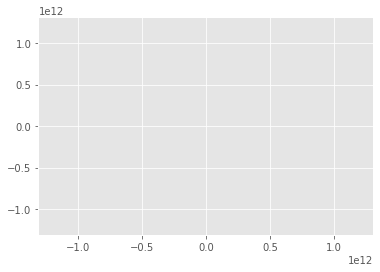

In [32]:
import os
from pathlib import Path
with open('../Gensim/m_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
wv_folder ='../Gensim/SG_data3/word2vec/'

files = os.listdir(wv_folder)

files = [x for x in filter(lambda x:x.split("_")[0] == 'medicines', files)]


import torch.optim as optim



files = [x for x in filter(lambda x:x.split("_")[2] in ['1000'] and x.split("_")[3].split('.')[1] == 'wv', files)]
file_paths = [ os.path.join(wv_folder, file) for file in files]
print(file_paths[0])
K = np.arange(10,101,10)



import os
from collections import defaultdict
from matplotlib import pyplot as plt    


for file,file_path in zip(files,file_paths[0:]):

  folder = Path((os.path.join("SG2",(file).split('_')[0]+'/'+ (file).split('_')[3].split('.')[0]+'/'+file.split('_')[2])))
  folder.mkdir(parents=True,exist_ok=True)
  print(folder)
  print(f'file_path {file_path}')
  model = GRUNet(input_dim=100, hidden_dim=200, output_dim=2806, n_layers=2, num_emd=8200, wv_file=file_path, tokenizer=tokenizer )
  model.init_weights(batch_size= BATCH_SIZE)
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), weight_decay=0.001)

  criterion = nn.BCELoss(reduction='mean')
  
  
  criterion = criterion.to(device)
  
  # print(f'1 {device} {model.embedding.weight.device}')
  config ={
      
      "embed_dim" : model.embedding.embedding_dim,
      "gru_hidden_size":model.gru.hidden_size,
      "gru_layers":  model.gru.num_layers,
      "avtivation":'sigmoid',
      "wv": f'{file}',
          
  }

  loses_list = ['train_loss','val_loss',]
  recall_list = ['train_recall', 'test_recall']    
  losses = defaultdict(list)    
  recalls = defaultdict(lambda: defaultdict(list))

  for i in range(30):
      print('started_training')
      # print(f'2 {device} {model.embedding.weight.device}')
      train_loss, val_loss = train(model=model, train_iterator=train_iter,
                                  optimizer=optimizer, criterion=criterion, val_iterator=val_iter, epochs=1)
      print('trained ', i)
      losses['train'].append(train_loss)
      losses['val'].append(val_loss)
      
      plt.style.use("ggplot")
      plt.figure()
      N = np.arange(1,len(losses['train'])+1)
      plt.plot(N,losses['train'], label='Train_loss')
      plt.plot(N,losses['val'], label='Val_loss')
      plt.legend()
      plt.xlabel("Epoch #")
      key ='loss'
      plt.ylabel(key)
      plt.title(f"Training {key} {i}")
      plt.savefig(os.path.join(folder,f'_{key}.png'))
      plt.close()  


      

      for k in K:
          recalls['train'][k].append(ham_loss(model=model,iterator=train_iter, k=k))
          recalls['test'][k].append(ham_loss(model=model,iterator=test_iter, k=k))

          plt.plot()
          plt.style.use("ggplot")
          plt.figure()
          N = np.arange(1,len(recalls['train'][k])+1)
          plt.plot(N,recalls['train'][k], label=f'Train_recall_{k}')
          plt.plot(N,recalls['test'][k], label=f'Test_recall_{k}')
          plt.legend()
          plt.xlabel("Epoch #")
          key ='recall'
          plt.ylabel(key)
          plt.title(f"Training {key} {i}")
          plt.savefig(os.path.join(folder,f'{key}_{k}.png'))
          plt.close()  
      
      

In [0]:
%debug

In [0]:
model.gru.all_weights

In [0]:
# %debug

In [0]:
model

In [0]:
x = model.gru.num_layers
x

In [0]:

config ={
      
      "embed_dim" : model.embedding.embedding_dim,
      "gru_hidden_size":model.gru.hidden_size,
      "gru_layers":  model.gru.num_layers,
      "avtivation":'sigmoid',
      # "wv": f'{file}',
          
  }


In [36]:
import numpy as np
K = np.arange(90,151,10)
K

array([ 90, 100, 110, 120, 130, 140, 150])

In [0]:
!mkdir medicnes/4

In [0]:
# folder ='diagnosis//'
folder ='medicines/4'

In [0]:
import json,os
with open(os.path.join(folder,'config.json'), 'w') as fp:
    json.dump(config, fp, indent=1)

started_training
epoch 1 epoch_loss 0.08398577988751836 val_loss 9.030361024564817 
trained  0
started_training
epoch 1 epoch_loss 0.06128123845603015 val_loss 7.488814656867795 
trained  1
started_training
epoch 1 epoch_loss 0.06141196100695713 val_loss 7.509198909527376 
trained  2
started_training
epoch 1 epoch_loss 0.061317266443291225 val_loss 7.506194893074662 
trained  3
started_training
epoch 1 epoch_loss 0.06130609102547169 val_loss 7.481792454460733 
trained  4
started_training
epoch 1 epoch_loss 0.06191745400428772 val_loss 7.522732537631925 
trained  5
started_training
epoch 1 epoch_loss 0.06148648659723836 val_loss 7.492417648826776 
trained  6
started_training
epoch 1 epoch_loss 0.0618868820067193 val_loss 7.522620050530686 
trained  7
started_training
epoch 1 epoch_loss 0.061637846904026496 val_loss 7.507682939893322 
trained  8
started_training
epoch 1 epoch_loss 0.06170028634369373 val_loss 7.517504093286238 
trained  9
started_training
epoch 1 epoch_loss 0.06212136124

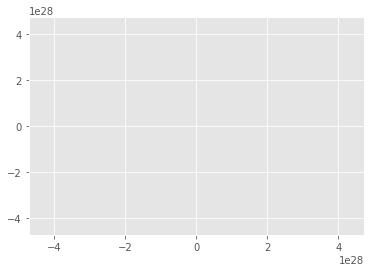

In [41]:
import os
from collections import defaultdict
from matplotlib import pyplot as plt
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), weight_decay=0.001)

criterion = nn.BCELoss(reduction='mean')


criterion = criterion.to(device)


loses_list = ['train_loss','val_loss',]
recall_list = ['train_recall', 'test_recall']    
losses = defaultdict(list)    
recalls = defaultdict(lambda: defaultdict(list))

for i in range(100):
    print('started_training')
    train_loss, val_loss = train(model=model, train_iterator=train_iter,
                                 optimizer=optimizer, criterion=criterion, val_iterator=val_iter, epochs=1)
    print('trained ', i)
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    
    plt.style.use("ggplot")
    plt.figure()
    N = np.arange(1,len(losses['train'])+1)
    plt.plot(N,losses['train'], label='Train_loss')
    plt.plot(N,losses['val'], label='Val_loss')
    plt.legend()
    plt.xlabel("Epoch #")
    key ='loss'
    plt.ylabel(key)
    plt.title(f"Training {key} {i}")
    plt.savefig(os.path.join(folder,f'_{key}.png'))
    plt.close()  




    for k in K:
        recalls['train'][k].append(ham_loss(model=model,iterator=train_iter, k=k))
        recalls['test'][k].append(ham_loss(model=model,iterator=test_iter, k=k))

        plt.plot()
        plt.style.use("ggplot")
        plt.figure()
        N = np.arange(1,len(recalls['train'][k])+1)
        plt.plot(N,recalls['train'][k], label=f'Train_recall_{k}')
        plt.plot(N,recalls['test'][k], label=f'Test_recall_{k}')
        plt.legend()
        plt.xlabel("Epoch #")
        key ='recall'
        plt.ylabel(key)
        plt.title(f"Training {key} {i}")
        plt.savefig(os.path.join(folder,f'_{key}_{k}.png'))
        plt.close()  
    
    

In [0]:
%debug

In [0]:
test_recall_100

In [0]:
torch.save(model.state_dict(), 'model5.pt')


In [0]:
model.load_state_dict(torch.load('model6.pt'))


In [0]:
val_loss=evaluate(model, val_iter,criterion)


In [0]:
val_loss

In [0]:
len(train_iter)

In [0]:
%debug

In [0]:

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [0]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = input_dim
    n_layers = 1
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [0]:
new_array = np.array([1.2, 3.4, 5.6])

In [0]:
train_ds[0].label.shape

In [0]:
x = BucketIterator(train_ds, batch_size=4, sort_key='length')
# for y in x:
#     y

In [0]:
x.create_batches

In [0]:
%debug

In [0]:
train_ds= DataFrameDataset(fields= fields, examples=train.iloc[:1])

In [0]:
y = BucketIterator(train_ds, batch_size=2,sort_key='length')

In [0]:
for x in y:
    print(x)

In [0]:
# train
%debug

In [0]:
x =torch.randn((3,8199))
model(x,3)

In [0]:
10 epochs : 0.55(100) , 0.4(60)

In [0]:
len(train_iter.dataset.examples)

In [0]:
measures = defaultdict(lambda: defaultdict(list))


In [0]:
measures[1]['11'].append('5')

In [0]:
measures

In [0]:
(final_df2.iloc[:]['input'].apply(lambda x: max([max(y) for y in x])) )

In [0]:
len(train_ds)

In [0]:
np.arange(1,losses['train']+1)

In [0]:
for batch in train_iter:
  print(f'batch.input.shape  {batch.input.shape}  batch.label.shape {batch.label.shape}' ) 

In [0]:
for sample in train_ds.examples:
  if sample.input.shape[0] != sample.label.shape[0]:
    print(f'{sample.input.shape[0]} {sample.label.shape[0]} {sample.length}')

In [0]:
from pathlib import Path

files = [x for x in filter(lambda x:x.split("_")[0] == 'diagnosis', files)]
x = Path((os.path.join("SG",(files[0]).split('_')[0]+'/'+ (files[0]).split('_')[3].split('.')[0])))
x


In [0]:

# files

In [0]:
ls

In [0]:
device

In [0]:
x = model.embedding.to(device)

In [0]:
x.weight

In [0]:
model.embedding.weight.device

In [0]:
final_df2[final_df2.label.apply(lambda x: sum([False if z.shape!=2806 else True for y in x for z in y])) != 0]

,input,label,length
SUBJECT_ID,,,


In [0]:
final_df2[final_df2.input.apply(lambda x: sum([False if len(y)!=1324 else True for y in x ])) == 0]


,input,label,length
SUBJECT_ID,,,
17,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",1
21,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",1
23,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0,...",1
34,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0,...",1
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0,...",2
...,...,...,...
99822,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0,...",2
99883,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0,...",1
99897,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",1
